# LSTM Time Series Forecasting
Examples of LSTM time series forecasting. Here are some articles if you are interested in learning more:
* <a href="https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/">How to Develop LSTM Models for Time Series Forecasting</a>

## Imports

In [1]:
import pandas as pd
import numpy as np
import time
from numpy.random import seed
from numpy.random import randn
from numpy import array
from math import sin, fabs, sqrt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM, ConvLSTM2D, Flatten
import matplotlib.pyplot as plt
%matplotlib inline

## Load Dataset

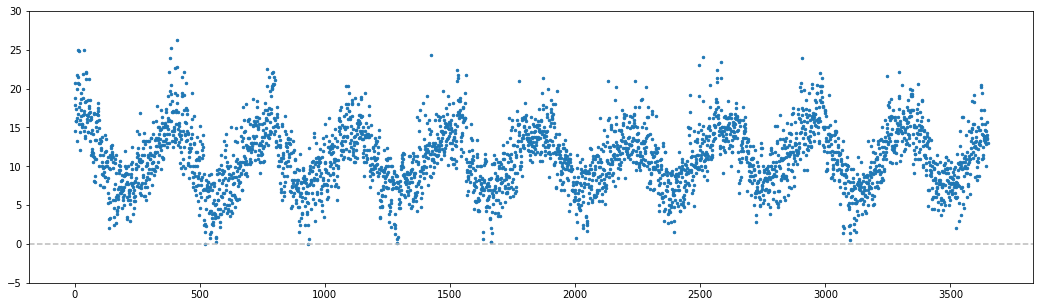

In [2]:
# Load min temperatures dataset
data = pd.read_csv("../data/daily-min-temperatures.csv").values
x = np.array(data[:,-1]).astype("float")
y = range(0,len(x))

# Plot
plt.figure(figsize=(18,5))
plt.ylim(-5,30)
plt.axhline(y=0, color="#bbbbbb", linestyle="dashed")
plt.scatter(y,x,s=6)
plt.show()

# Settings
n_steps = 8 # 16
n_features = 1
xt = x[n_steps:]
yt = y[n_steps:]

## Useful functions

In [3]:
# Calculate prediction error
def calc_error(xhat):
    mse = 0
    mae = 0
    for v,vhat in zip(xt, xhat):
        mae += fabs(v-vhat)
        mse += (v-vhat)**2
    mae /= len(xt)
    mse /= len(xt)

    print("Result: mae={0:.3f}, mse={1:.3f}, rmse={2:.3f}".format(mae, mse, sqrt(mse)))

# Plot result
def plot_result(xhat):
    plt.figure(figsize=(18,5))
    plt.ylim(-5,30)
    plt.axhline(y=0, color="#bbbbbb", linestyle="dashed")
    plt.plot(yt, xhat, c="red")
    plt.scatter(yt, xt, c="blue", s=6)
    plt.show()

# Train and evaluate model
def train_and_evaluate(model, X, epochs=200):
    # Start timer
    start = time.time()

    # Fit (train) model
    model.fit(X, y, epochs=epochs, verbose=0)
    
    # Stop timer
    end = time.time()
    
    # Make predictions
    xhat = model.predict(X).flatten()
    
    # Show results
    print("Time elapsed: {0:0.2f} sec".format(end - start))
    calc_error(xhat)
    plot_result(xhat)

## Data Preparation

In [4]:
# Split a univariate sequence into samples
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # Find the end of this pattern
        end_ix = i + n_steps
        # Check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # Gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

# Split into samples
Xs, y = split_sequence(x, n_steps)

## Vanilla LSTM

Time elapsed: 85.06 sec
Result: mae=1.644, mse=4.570, rmse=2.138


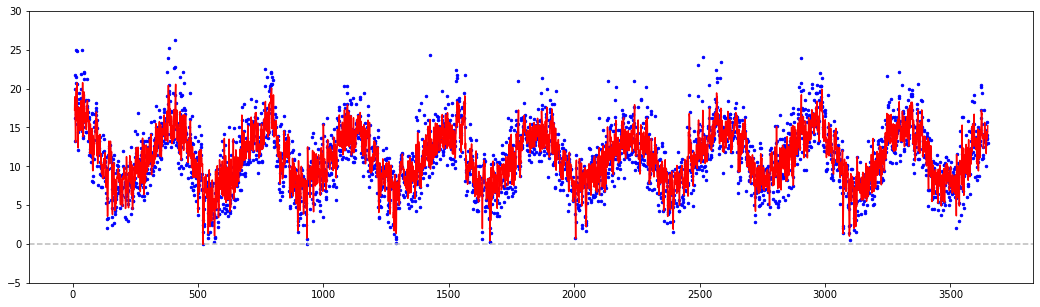

In [5]:
# Define model
model = Sequential()
model.add(LSTM(64, activation="relu", input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer="adam", loss="mse")

# Reshape from [samples, timesteps] into [samples, timesteps, features]
X = Xs.reshape((Xs.shape[0], Xs.shape[1], 1))

# Train and evaluate model
train_and_evaluate(model, X, epochs=200)

## Stacked LSTM

Time elapsed: 155.82 sec
Result: mae=1.405, mse=3.416, rmse=1.848


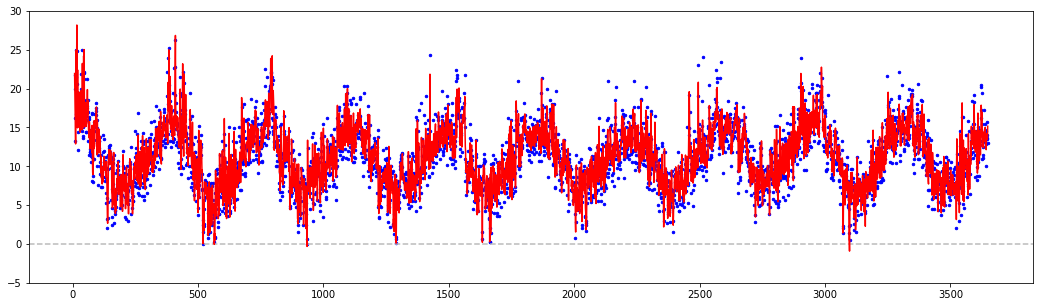

In [6]:
# Define model
model = Sequential()
model.add(LSTM(64, activation="relu", return_sequences=True, input_shape=(n_steps, n_features)))
model.add(LSTM(64, activation="relu"))
model.add(Dense(1))
model.compile(optimizer="adam", loss="mse")

# Reshape from [samples, timesteps] into [samples, timesteps, features]
X = Xs.reshape((Xs.shape[0], Xs.shape[1], n_features))

# Train and evaluate model
train_and_evaluate(model, X, epochs=200)

## ConvLSTM

Time elapsed: 114.23 sec
Result: mae=1.518, mse=3.925, rmse=1.981


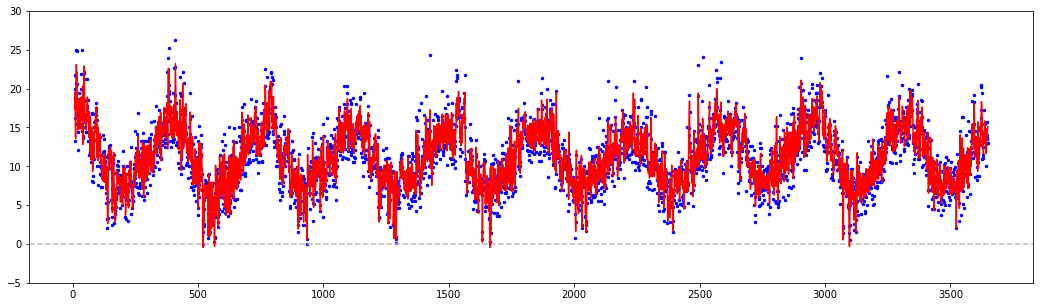

In [7]:
# Settings
n_seq = 4
n_step = 2

# Define model
model = Sequential()
model.add(ConvLSTM2D(filters=64, kernel_size=(1,2), activation="relu", input_shape=(n_seq, 1, n_step, n_features)))
model.add(Flatten())
model.add(Dense(1))
model.compile(optimizer="adam", loss="mse")

# Reshape from [samples, timesteps] into [samples, timesteps, rows, columns, features]
X = Xs.reshape((Xs.shape[0], n_seq, 1, n_step, n_features))

# Train and evaluate model
train_and_evaluate(model, X, epochs=200)

## Forecasting
Evaluates how well forecasting works.

Time elapsed: 72.15 sec
Result: mae=1.740, mse=4.939, rmse=2.222


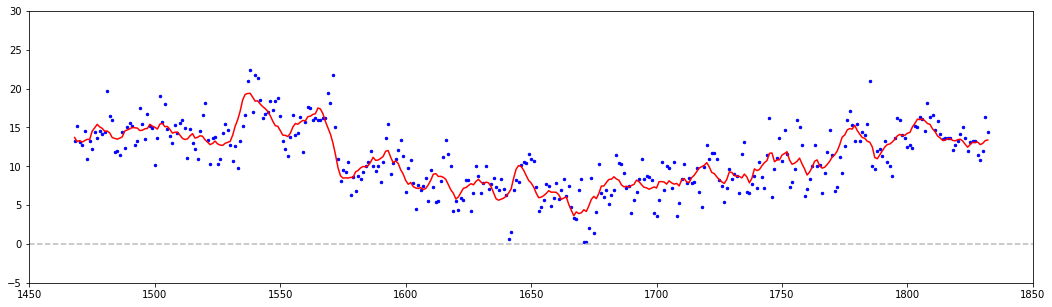

In [8]:
Xs, y = split_sequence(x, n_steps)

# Reshape from [samples, timesteps] into [samples, timesteps, features]
X = Xs.reshape((Xs.shape[0], Xs.shape[1], 1))

# Train on four years data
tlim = 365 * 4

# Cut out training part
X_train = X[:tlim]
y_train = X[:tlim]

# Start timer
start = time.time()
    
# Define Stacked LSTM model
model = Sequential()
model.add(LSTM(64, activation="relu", return_sequences=True, input_shape=(n_steps, n_features)))
model.add(LSTM(64, activation="relu"))
model.add(Dense(1))
model.compile(optimizer="adam", loss="mse")
# Fit model
model.fit(X_train, y_train, epochs=200, verbose=0)

# Forecast one year
no_f = 365

# Forecasts
xhat = []

# Error metrics
mae = 0
mse = 0

# Iterate over number of forecasts
for i in range(0, no_f):
    # Cut out input
    Xn = X[tlim+i-1:tlim+i]
    
    # Make a one-step forecast
    fval = model.predict(Xn).flatten()[0]
    xhat.append(fval)
    # Actual value
    aval = x[tlim+i]
    
    # Errors
    mae += fabs(fval-aval)
    mse += (fval-aval)**2
    
# Calculate average errors
mae /= no_f
mse /= no_f

# Stop timer
end = time.time()

# Show results
print("Time elapsed: {0:0.2f} sec".format(end - start))
print("Result: mae={0:.3f}, mse={1:.3f}, rmse={2:.3f}".format(mae, mse, sqrt(mse)))

# Plot
plt.figure(figsize=(18,5))
plt.ylim(-5,30)
plt.axhline(y=0, color="#bbbbbb", linestyle="dashed")
plt.plot(yt[tlim:tlim+no_f], xhat, c="red")
plt.scatter(yt[tlim:tlim+no_f], x[tlim:tlim+no_f], c="blue", s=6)
plt.show()